In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



2024-10-20 19:54:04.431385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# 1. Create a small dataframe
data = {'time': range(50), 'value': np.sin(np.linspace(0, 10, 50))}
df = pd.DataFrame(data)
print(df) 

    time     value
0      0  0.000000
1      1  0.202668
2      2  0.396924
3      3  0.574706
4      4  0.728635
5      5  0.852322
6      6  0.940633
7      7  0.989903
8      8  0.998087
9      9  0.964846
10    10  0.891559
11    11  0.781268
12    12  0.638550
13    13  0.469330
14    14  0.280629
15    15  0.080282
16    16 -0.123398
17    17 -0.321956
18    18 -0.507152
19    19 -0.671298
20    20 -0.807582
21    21 -0.910347
22    22 -0.975328
23    23 -0.999829
24    24 -0.982831
25    25 -0.925041
26    26 -0.828858
27    27 -0.698272
28    28 -0.538705
29    29 -0.356779
30    30 -0.160045
31    31  0.043332
32    32  0.244910
33    33  0.436323
34    34  0.609627
35    35  0.757628
36    36  0.874184
37    37  0.954457
38    38  0.995115
39    39  0.994471
40    40  0.952552
41    41  0.871097
42    42  0.753487
43    43  0.604603
44    44  0.430626
45    45  0.238775
46    46  0.037014
47    47 -0.166283
48    48 -0.362678
49    49 -0.544021


In [5]:
# 2. Preprocess the data (scaling and reshaping)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))
print(scaled_data)

[[0.50043575]
 [0.60187541]
 [0.69910482]
 [0.78808848]
 [0.86513313]
 [0.92704103]
 [0.97124269]
 [0.99590353]
 [1.        ]
 [0.98336208]
 [0.94668032]
 [0.8914772 ]
 [0.82004392]
 [0.73534532]
 [0.6408968 ]
 [0.54061846]
 [0.43867233]
 [0.33928969]
 [0.24659541]
 [0.16443677]
 [0.09622375]
 [0.04478753]
 [0.01226297]
 [0.        ]
 [0.0085076 ]
 [0.03743265]
 [0.08557463]
 [0.1509354 ]
 [0.23080217]
 [0.32186007]
 [0.42032974]
 [0.52212422]
 [0.62301851]
 [0.71882501]
 [0.80556727]
 [0.87964507]
 [0.93798379]
 [0.97816211]
 [0.99851241]
 [0.99819006]
 [0.97720844]
 [0.93643838]
 [0.87757206]
 [0.80305271]
 [0.71597326]
 [0.61994793]
 [0.51896225]
 [0.41720764]
 [0.3189074 ]
 [0.22814149]]


In [19]:
# Convert to time series format: Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 5
X, y = create_sequences(scaled_data, sequence_length)
print(X,y)
print(X.shape)

[[[0.50043575]
  [0.60187541]
  [0.69910482]
  [0.78808848]
  [0.86513313]]

 [[0.60187541]
  [0.69910482]
  [0.78808848]
  [0.86513313]
  [0.92704103]]

 [[0.69910482]
  [0.78808848]
  [0.86513313]
  [0.92704103]
  [0.97124269]]

 [[0.78808848]
  [0.86513313]
  [0.92704103]
  [0.97124269]
  [0.99590353]]

 [[0.86513313]
  [0.92704103]
  [0.97124269]
  [0.99590353]
  [1.        ]]

 [[0.92704103]
  [0.97124269]
  [0.99590353]
  [1.        ]
  [0.98336208]]

 [[0.97124269]
  [0.99590353]
  [1.        ]
  [0.98336208]
  [0.94668032]]

 [[0.99590353]
  [1.        ]
  [0.98336208]
  [0.94668032]
  [0.8914772 ]]

 [[1.        ]
  [0.98336208]
  [0.94668032]
  [0.8914772 ]
  [0.82004392]]

 [[0.98336208]
  [0.94668032]
  [0.8914772 ]
  [0.82004392]
  [0.73534532]]

 [[0.94668032]
  [0.8914772 ]
  [0.82004392]
  [0.73534532]
  [0.6408968 ]]

 [[0.8914772 ]
  [0.82004392]
  [0.73534532]
  [0.6408968 ]
  [0.54061846]]

 [[0.82004392]
  [0.73534532]
  [0.6408968 ]
  [0.54061846]
  [0.43867233]]


In [8]:
# Split into training and testing data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [9]:
# Reshape X for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train,X_test)

[[[0.50043575]
  [0.60187541]
  [0.69910482]
  [0.78808848]
  [0.86513313]]

 [[0.60187541]
  [0.69910482]
  [0.78808848]
  [0.86513313]
  [0.92704103]]

 [[0.69910482]
  [0.78808848]
  [0.86513313]
  [0.92704103]
  [0.97124269]]

 [[0.78808848]
  [0.86513313]
  [0.92704103]
  [0.97124269]
  [0.99590353]]

 [[0.86513313]
  [0.92704103]
  [0.97124269]
  [0.99590353]
  [1.        ]]

 [[0.92704103]
  [0.97124269]
  [0.99590353]
  [1.        ]
  [0.98336208]]

 [[0.97124269]
  [0.99590353]
  [1.        ]
  [0.98336208]
  [0.94668032]]

 [[0.99590353]
  [1.        ]
  [0.98336208]
  [0.94668032]
  [0.8914772 ]]

 [[1.        ]
  [0.98336208]
  [0.94668032]
  [0.8914772 ]
  [0.82004392]]

 [[0.98336208]
  [0.94668032]
  [0.8914772 ]
  [0.82004392]
  [0.73534532]]

 [[0.94668032]
  [0.8914772 ]
  [0.82004392]
  [0.73534532]
  [0.6408968 ]]

 [[0.8914772 ]
  [0.82004392]
  [0.73534532]
  [0.6408968 ]
  [0.54061846]]

 [[0.82004392]
  [0.73534532]
  [0.6408968 ]
  [0.54061846]
  [0.43867233]]


In [11]:
# 3. Define a simple LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))  # Output layer for regression


model.compile(optimizer='adam', loss='mse')


In [12]:
# 4. Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=1, verbose=0)

In [13]:
# 5. Test the model: Make predictions
y_pred = model.predict(X_test)
print(y_pred)


1/1 [==============================] - 0s 224ms/step
[[0.9381456 ]
 [0.8776832 ]
 [0.8015971 ]
 [0.71320534]
 [0.61995083]
 [0.5218082 ]
 [0.41924784]
 [0.31915274]
 [0.22827667]]


In [14]:
# Inverse transform the scaled values to original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

In [15]:
# 6. Print the evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.1108978692215819e-05


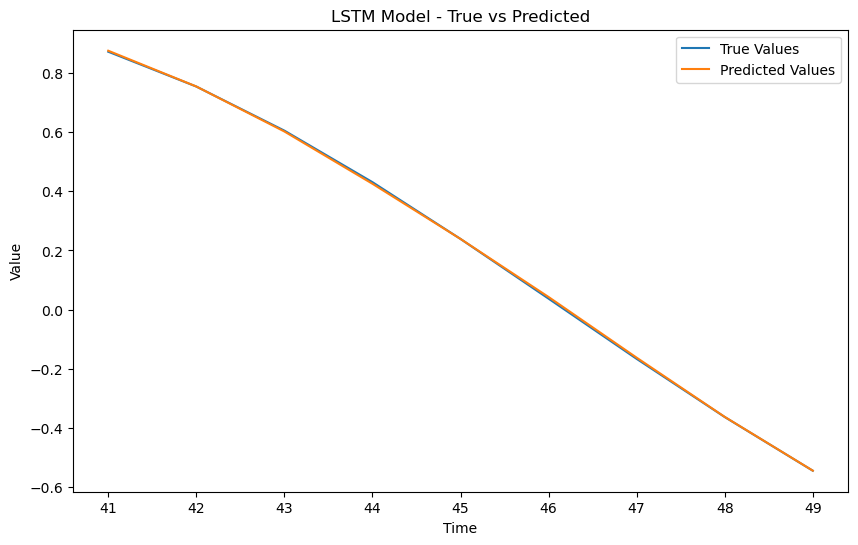

In [16]:
# 7. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['time'][sequence_length + split:], y_test_rescaled, label='True Values')
plt.plot(df['time'][sequence_length + split:], y_pred_rescaled, label='Predicted Values')
plt.title('LSTM Model - True vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

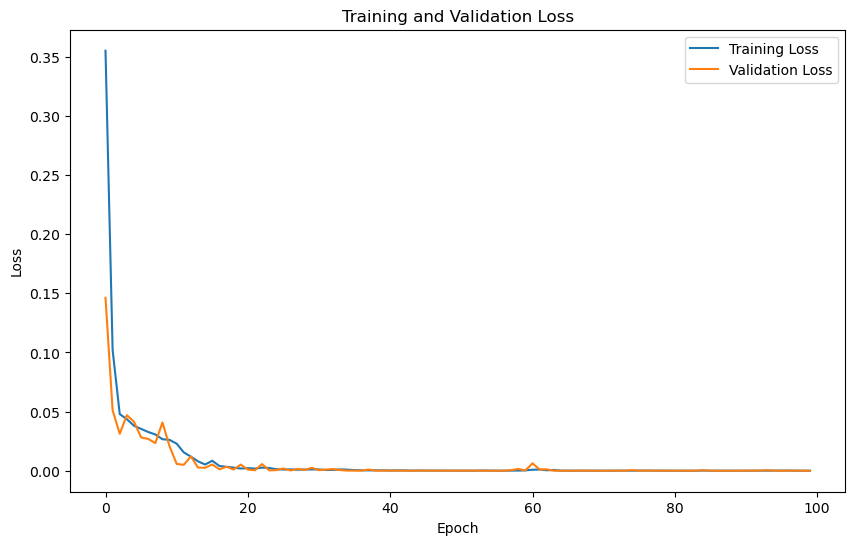

In [17]:
# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
